In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image,ImageFilter
import warnings
import scipy.optimize as opt
import scipy as sp
import cmath
%matplotlib inline
warnings.filterwarnings('ignore')

font = {'family' : 'Ubuntu',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)


In [2]:
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             filelist.append(os.path.join(root,file))
    return filelist

def getImageValues(Files,EventLimit=1):
    if(type(Files) is list):
        values={}
        count=0
        for file in Files:
            img1=Image.open(file)
            imgArray=np.array(img1)
            values[count]=imgArray
            count+=1
            if(EventLimit==count):
                break
        print(f" {count} frames in dictinary ")
    else:
        img1=Image.open(Files)
        values=np.array(img1)
    return values

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data



def TwoDGaussianElliptical(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value

def TwoDGaussianEllipticalFlat(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value.ravel()
        
def gaussian1d(mu,sigma,bins):
    return 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2))


def MaskCreate(pixel,radius,center,plot=False):
    XPixel,YPixel=pixel
    centerX,centerY=center
    x=np.arange(0,XPixel,1)
    y=np.arange(0,YPixel,1)
    xx,yy=np.meshgrid(x,y)
    rr=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    mask=rr<radius
    values=np.zeros(rr.shape)
    values[mask]=1
    if(plot):
        plt.figure(figsize=(12,8),dpi=300)
        plt.title("Mask Position")
        plt.xlabel("PixelX")
        plt.ylabel("PixelY")
        plt.imshow(values,cmap="gray",origin="lower")
        plt.show()
    
    return mask,values,[centerX,centerY]
    

    

def DrawCircle(centerx,centery,r,pixelSize,amount):
    x=np.arange(0,pixelSize,1).optimize
    xx,yy=np.meshgrid(x,x)
    rr=np.sqrt((xx-centerx)**2 + (yy-centery)**2)
    print(rr.shape)
    values=np.ones(rr.shape)*-1
    plt.figure(figsize=(12,8),dpi=300)
    count=0
    plt.title("Radial Average")
    #plt.xlim(0,512)
    #plt.ylim(0,512)
    print(r)
    for i in r:
        RadiusMask=(rr>=i-0.5)  & (rr<i+0.5)
        values[RadiusMask]=i
        if (count>=amount):
            break;
        count+=1
    plt.contourf(x,x,values,cmap='viridis',levels=r)
    plt.xlabel("kx")
    plt.ylabel("ky")
    plt.colorbar(label="k")
    plt.show()
    
def RadialFilter(wiener,size,xcenter,ycenter,radius):
    xx=np.linspace(0,size,size)
    grid=np.meshgrid(xx,xx)
    r=np.round(np.sqrt((grid[0]-xcenter)**2+(grid[1]-ycenter)**2))
    MaskIn=r<radius
    ones=np.zeros(r.shape)
    positions=np.where(MaskIn)
    print("XXX\n")
    print(grid[0])
    print("YYY\n")
    print(grid[1])
    print("RRR\n")

    print(r)
    positionR=np.floor(np.sqrt((positions[0]-xcenter)**2+(positions[1]-ycenter)**2))
    print(positionR.max())
    print(positionR.min())

    Wiener1d=np.array([])

    for i in positionR:
        Wiener1d=np.append(Wiener1d,wiener[int(i)])
        
    ones[MaskIn]=Wiener1d
    
    return ones

def TwoDGaussian(xy,Amp,x0,sigmax,y0,sigmay=None):
    x,y=xy
    if(sigmay==None):
        sigmay=sigmax
    value=Amp*np.exp(-((x-x0)**2/(2*sigmax**2)+(y-y0)**2/(2*sigmay**2)))
    return value



def RadialAverage(pws,radius,Amou,center=None):
    xp=np.arange(pws.shape[0])
    yp=np.arange(pws.shape[0])
    xx,yy=np.meshgrid(xp,yp)
    pws=np.fft.fftshift(pws)
    if not center:
        center=[pws.shape[0]/2,pws.shape[0]/2]
    R=np.sqrt((xx-center[0])**2+(yy-center[1])**2)
    
    radial = lambda r:pws[(R>=r-0.5) & (R<r+0.5)].mean()
    r=np.arange(1,radius,1)
    PWS1D=np.vectorize(radial)(r)
    return PWS1D

def my_ceil(a, precision=0):
    return np.true_divide(np.ceil(a * 10**precision), 10**precision)

def my_floor(a, precision=0):
    return np.true_divide(np.floor(a * 10**precision), 10**precision)



In [3]:
#Particles=PickleITRead("/home/ilker/Downloads/imgs.p")

In [52]:
##### 3 Source in a picture
#Get Enviroment Variable User
user=os.getenv('USER')

#Directory="/media/"+user+"/Ilker_SSD/10_07bar_6_21_23"
Directory="/home/"+user+"/Desktop/10_07bar_6_21_23"
# EL 13kV/cm
## Drift 440,250,125 V/cm
Folders=["17k_8k_7k","13.57k_4.57k_4k","11.3k_2.3k_2k"]

# EL 11kV/cm
## Drift 440,250,125 V/cm
#Folders=["16k_8k_7k","12.57k_4.57k_4k","10.3k_2.3k_2k"]


# EL 10kV/cm
## Drift 440,250,125 V/cm
#Folders=["15k_8k_7k","11.57k_4.57k_4k","9.5k_2.3k_2k"]
## "Time"
Time="27ms"
Path=Directory+"/"+Folders[0]+"/"+Time
#Path=Directory+"/"+"s1"+"/"+Time
Images=getImageValues(ListofFiles(Path),-1)

SplitPath=Path.split("/")
Titlevalues=SplitPath[-2:]

 10000 frames in dictinary 


In [5]:
print(Titlevalues)

['16k_8k_7k', '1s']


In [6]:
FixedSimg=Images[1]
#plt.imshow(Simg,cmap=plt.cm.jet,origin='lower',vmin=np.mean(Simg),vmax=np.max(Simg))


In [7]:
#plt.imshow(Images2[4],cmap=plt.cm.jet,origin='lower')
#plt.imshow(Images[200],cmap=plt.cm.jet,origin='lower',alpha=0.5)


In [198]:
## Average the images
def AvergImage(Images,rangex,Single=True):
    img=np.zeros(Images[0].shape)
    if (rangex>len(Images.keys())):
        rangex=len(Images.keys())
    # Average only one set
    if(Single):
        for i in range(0,rangex):
            img+=Images[i]
        img=img/rangex
        return img
    else: # Average Multiple Sets of Images
        cnt=0
        fImages=[]
        while(cnt<=len(Images.keys())-1):
            img+=Images[cnt]
            if (cnt%(rangex)==0 and cnt>0):
                fImages.append(img/rangex)
                img=np.zeros(Images[0].shape)
            cnt=cnt+1
        return fImages
    
    

In [202]:
theImage=AvergImage(Images,100,Single=True)


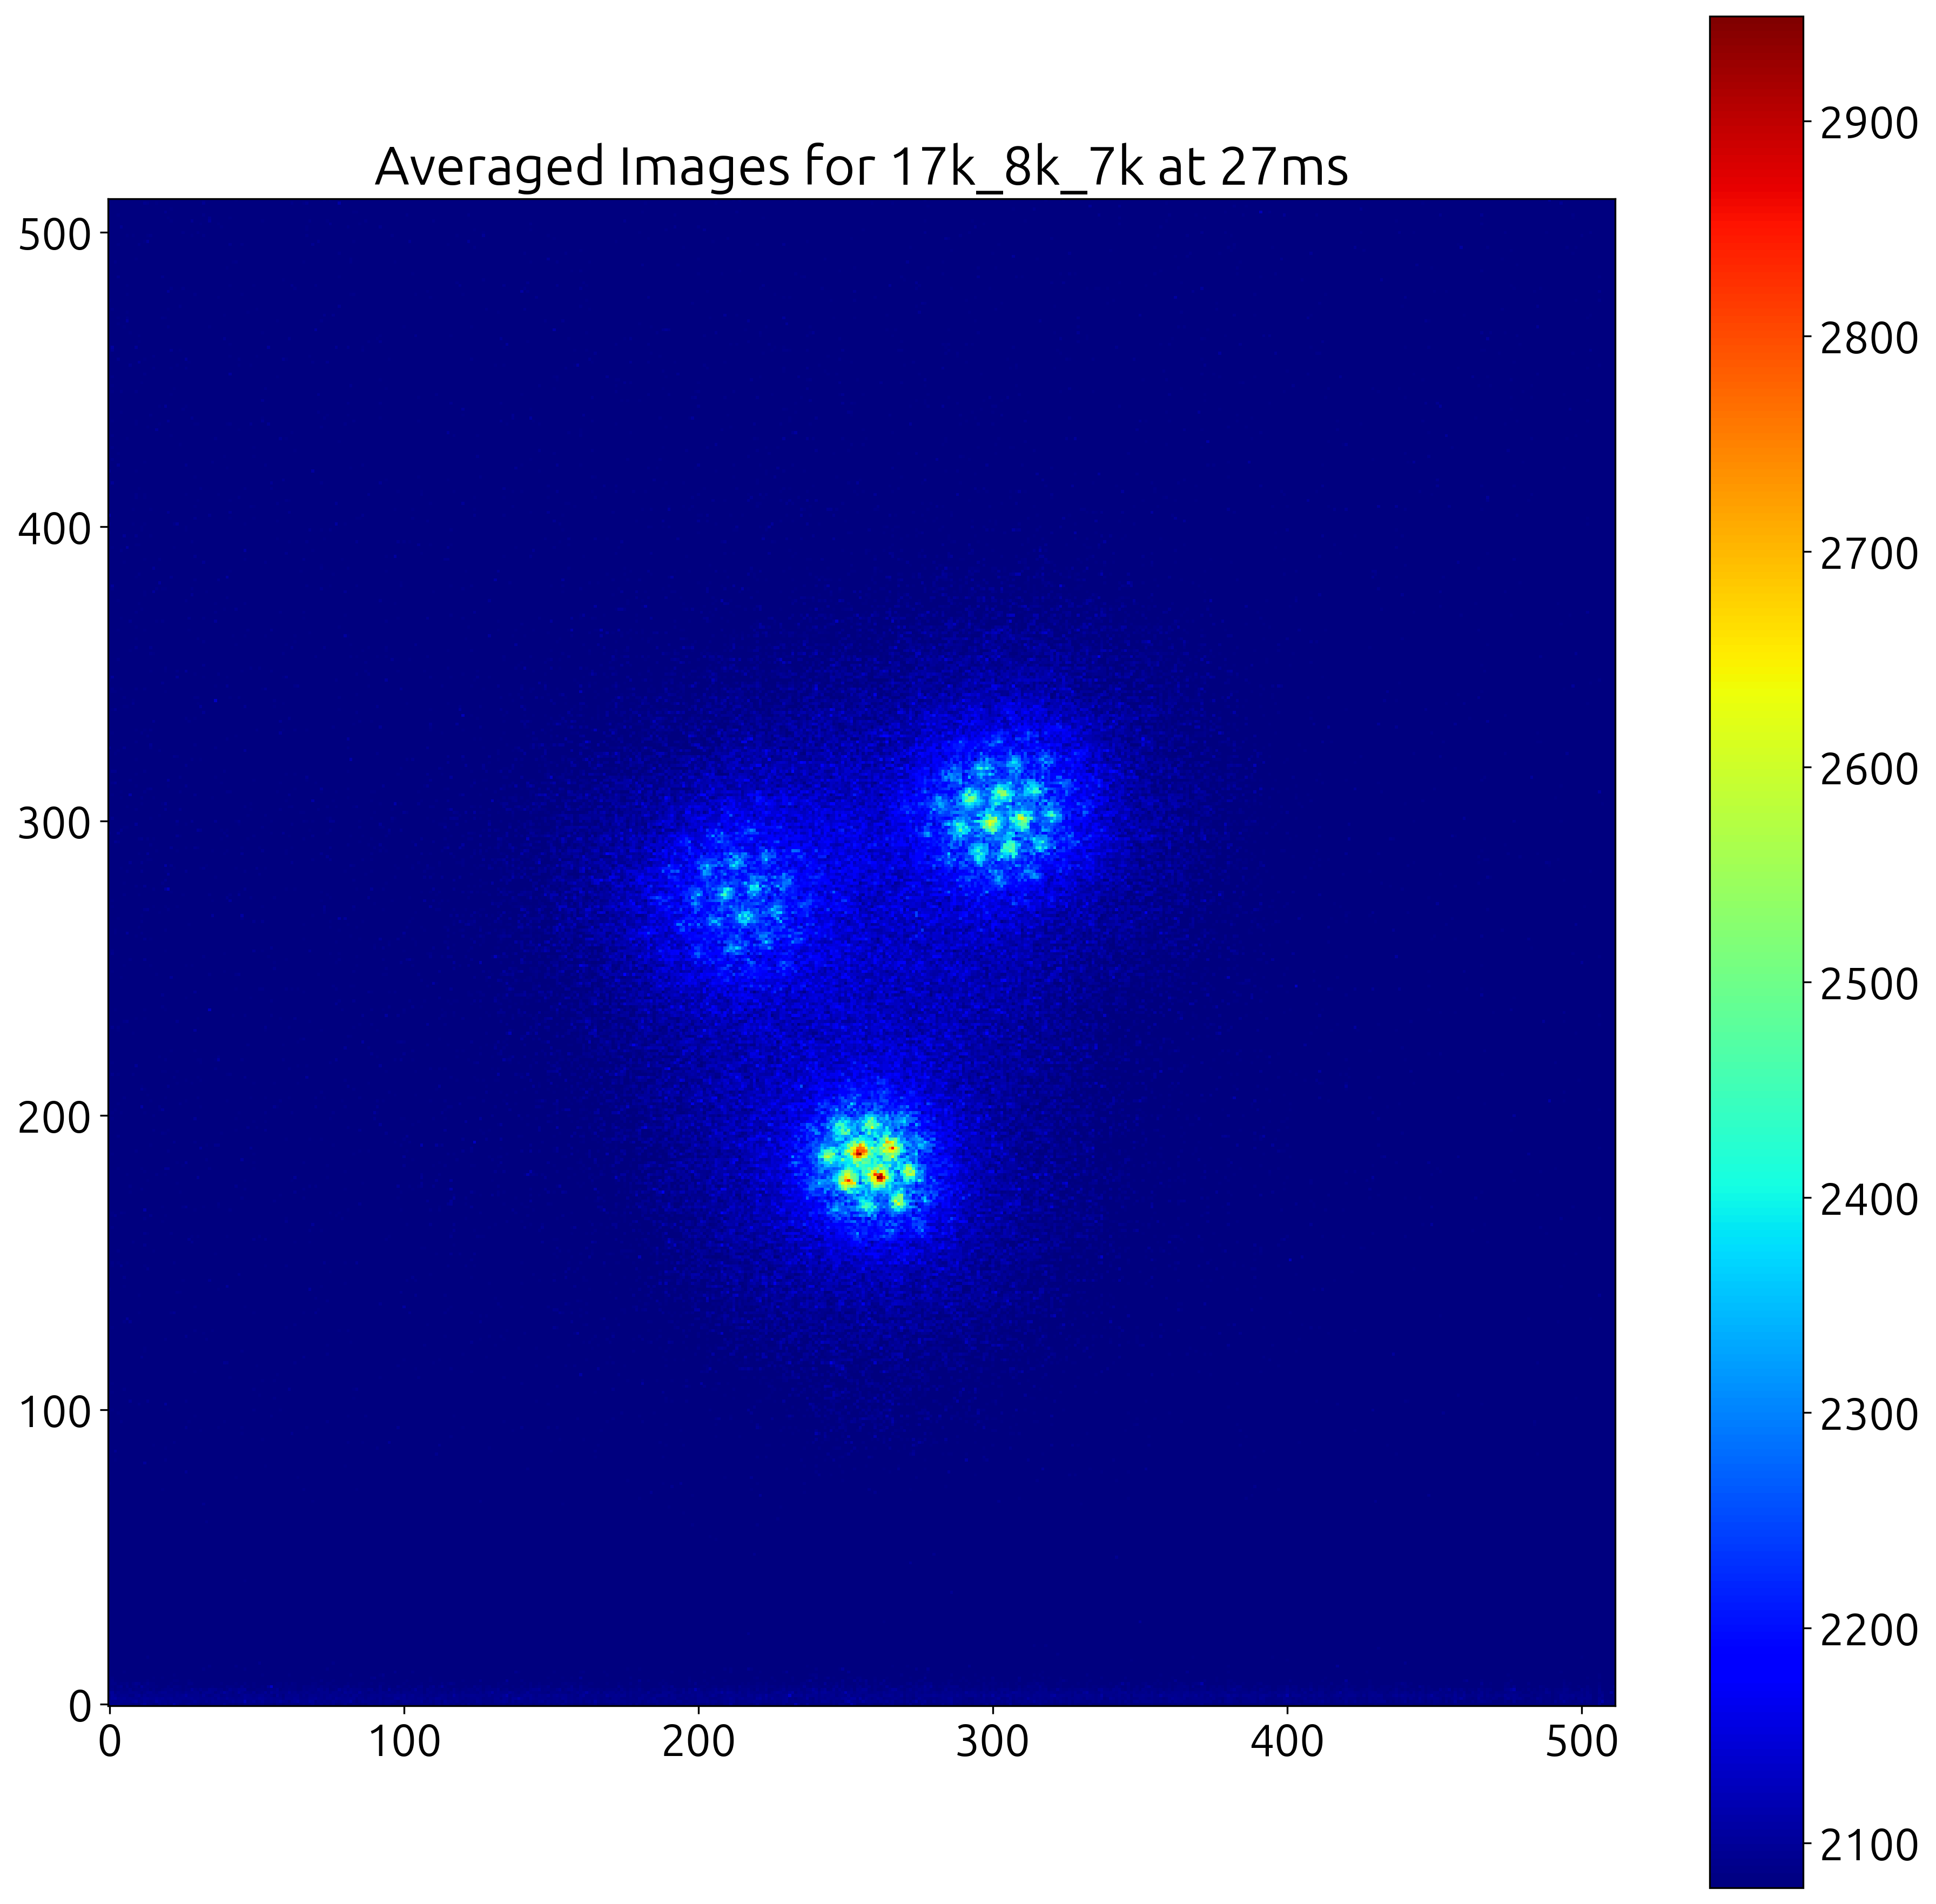

In [203]:


#theImage=np.fft.fft2(theImage)*Wiener["WienerandLowPass"]
#theImage=np.fft.ifft2(theImage)
#theImage=np.real(theImage)
plt.figure(figsize=(15,15),dpi=300)
Title=f"Averaged Images for {Titlevalues[0]} at {Titlevalues[1]}"
plt.title(Title)

plt.imshow(theImage,cmap=plt.cm.jet,vmin=np.mean(theImage),vmax=np.max(theImage),origin="lower")
PixelSize=50
CenterPoint=(215,270)
Needle15cm_Mask=MaskCreate(PixelShape,PixelSize,CenterPoint)
#plt.scatter(*CenterPoint,s=100,color="y",marker="o") ##  15cm

CenterPoint=(298,297)
Needle10cm_Mask=MaskCreate(PixelShape,PixelSize,CenterPoint)
#plt.scatter(*CenterPoint,s=100,color="r",marker="o") ##  10cm

CenterPoint=(261,180)
#CenterPoint=(261,179)
Needle5cm_Mask=MaskCreate(PixelShape,PixelSize,CenterPoint)
#plt.scatter(*CenterPoint,s=100,color="k",marker="o") ##  5cm
CenterPoint=(238,176)
#plt.scatter(*CenterPoint,s=100,color="r",marker="o") ##  5cm
plt.colorbar()
Noise=MaskCreate(PixelShape,80,(110,400),False)
#Particles=PickleITRead("/home/ilker/Downloads/imgs.p")


In [207]:
Error = lambda Observed,Expected:abs(Observed-Expected)/Expected
def WAverage(img):
    x = np.linspace(0, img.shape[0], img.shape[0])
    y=  np.linspace(0, img.shape[1], img.shape[1])
    xx, yy = np.meshgrid(x, y)

    PixelX=xx.ravel()
    PixelY=yy.ravel()
    
    
    weights1d=img.ravel()
    Mult1dX=np.sum(weights1d*PixelX)
    Sumweight1dX=np.sum(weights1d)
    ax=Mult1dX/Sumweight1dX
    
    
    Mult1dY=np.sum(weights1d*PixelY)
    Sumweight1dX=np.sum(weights1d)
    Mult1dY=np.sum(weights1d*PixelY)
    Sumweight1dY=np.sum(weights1d)
    ay=Mult1dY/Sumweight1dY
    
    return ax,ay
#x = np.linspace(0, theImage.shape[0], theImage.shape[0])
#y=  np.linspace(0, theImage.shape[1], theImage.shape[1])
#xx, yy = np.meshgrid(x, y)
#WeightedPixelX=np.average(xx,weights=theImage)
#WeightedPixelY=np.average(yy,weights=theImage)



In [208]:
def WeightedAverage(img,mask,Radius):
    ## Method 2 Weighted Average Estimation
    x = np.linspace(0, img.shape[0], img.shape[0])
    y=  np.linspace(0, img.shape[1], img.shape[1])
    xx, yy = np.meshgrid(x, y)
    
    rr=np.sqrt(xx**2+yy**2)
    
    # Estimate the Max Intensity
    mAx=np.max(img[mask[0]])
    MaxMask2D=mAx==img*mask[0]
    MaxMask1D=mAx==img[mask[0]]
    
    # Estimate the Max Intensity in a given region
    Cmax=(np.where(MaxMask2D)[1],np.where(MaxMask2D)[0])
    print(f"Max is {img[Cmax]} at {Cmax}")
    
    ## Create a Mask that is Centered in Maximum Intensity
    cc=MaskCreate(PixelShape,Radius,(Cmax[0],Cmax[1]),False)
    
    ## Estimate the Mean
    #Mean=np.average(img[cc[0]],weights=rr[cc[0]])
    
        ## Find the Pixel that is closest to mean
    #ErrorV=Error(img[cc[0]],Mean)
    #MinLoc=np.where(ErrorV==np.min(ErrorV))
    #PixelLoc=np.where(img*cc[0]==img[cc[0]][MinLoc])
    #print(PixelLoc)
   
    WeightedPixelX=np.average(xx[cc[0]],weights=img[cc[0]])
    WeightedPixelY=np.average(yy[cc[0]],weights=img[cc[0]])
    
    PixelX=xx[cc[0]]
    PixelY=yy[cc[0]]
    weightsA=img[cc[0]]
    
    np.average(PixelX*PixelY,weights=weightsA)
    print(f"Weighted Average {(WeightedPixelX,WeightedPixelY)} ")
    return [[WeightedPixelX,WeightedPixelY],[Cmax[0][0],Cmax[1][0]]]
    

In [209]:
Needle5cm_WAvg=WeightedAverage(theImage,Needle5cm_Mask,30)
Needle10cm_WAvg=WeightedAverage(theImage,Needle10cm_Mask,30)
Needle15cm_WAvg=WeightedAverage(theImage,Needle15cm_Mask,30)

Max is [2144.68] at (array([261]), array([179]))
Weighted Average (261.38506991061513, 179.57929842183916) 
Max is [2408.02] at (array([310]), array([301]))
Weighted Average (310.3687797505541, 301.6308142030942) 
Max is [2181.5] at (array([209]), array([275]))
Weighted Average (209.53660058184127, 275.50953683711) 


In [210]:
print(Needle5cm_WAvg)

[[261.38506991061513, 179.57929842183916], [261, 179]]


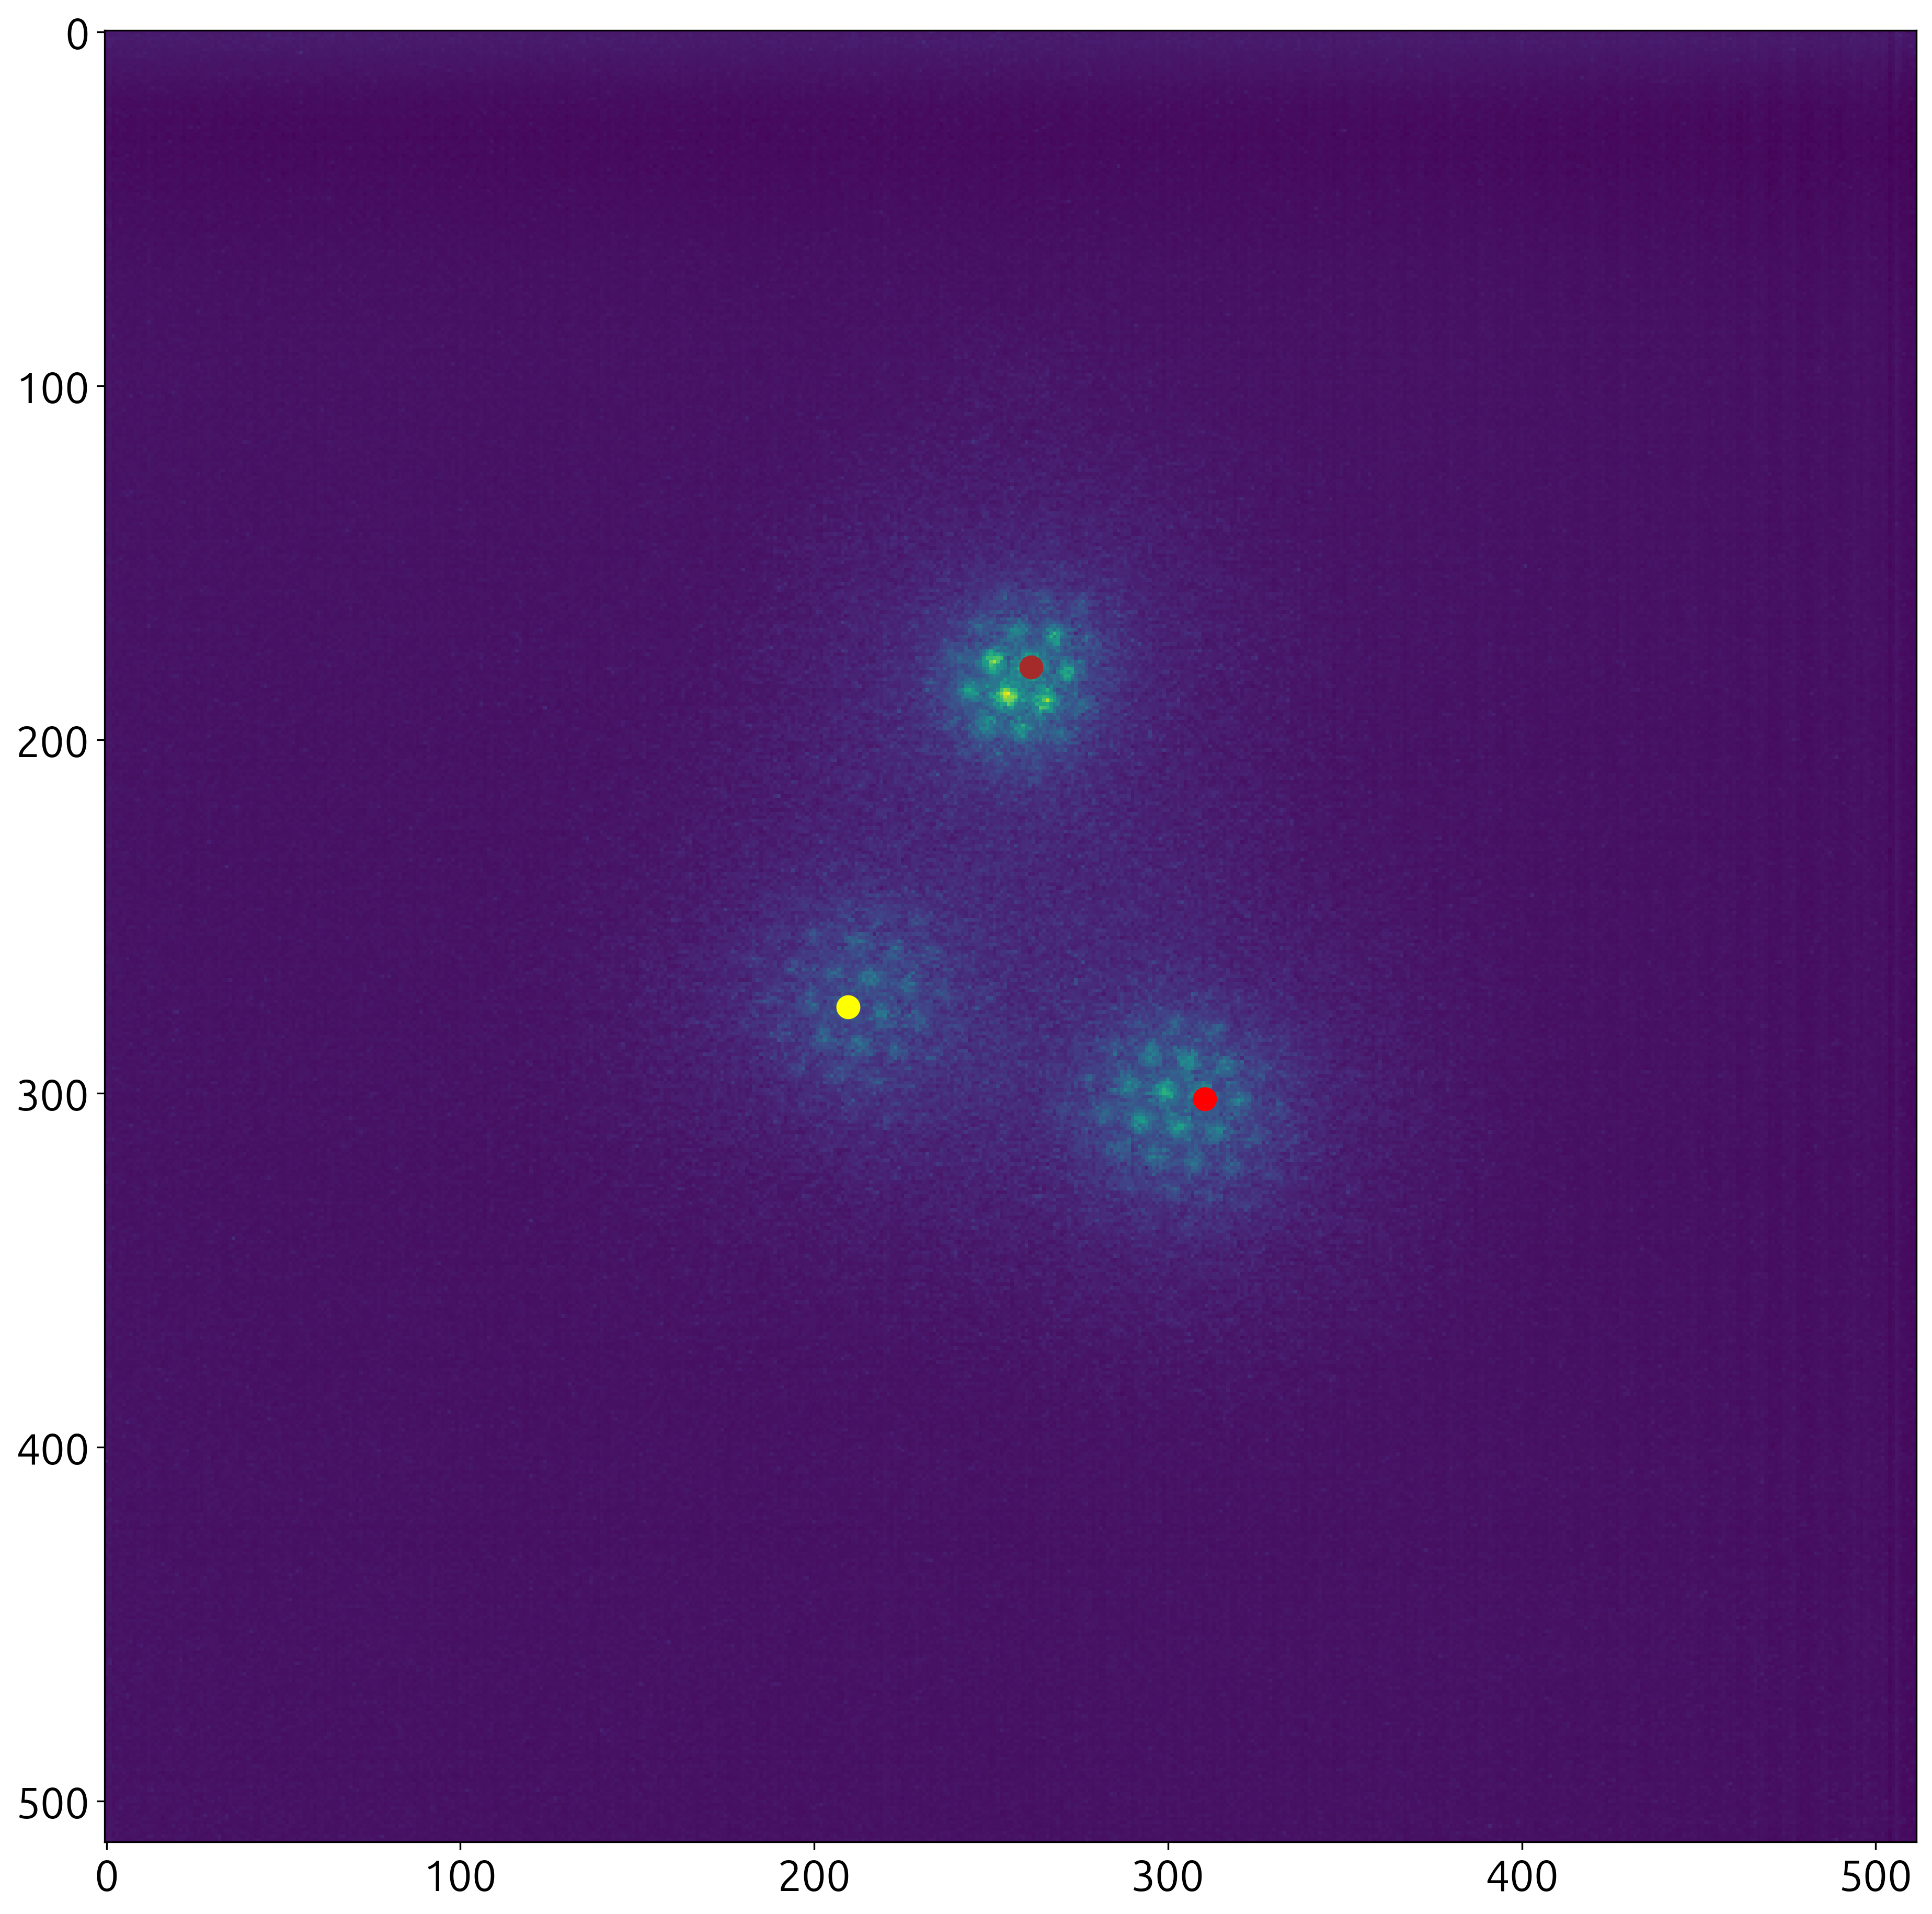

In [211]:
#print(f"Mean is {np.mean(theImage[cc[0]])}")
plt.figure(figsize=(15,15),dpi=300)
plt.imshow(theImage)
plt.scatter(*Needle5cm_WAvg[0],color="brown",s=100)
plt.scatter(*Needle10cm_WAvg[0],color="red",s=100)
plt.scatter(*Needle15cm_WAvg[0],color="yellow",s=100)

#plt.scatter(x=xx[1][0],y=xx[1][1],color="red")
plt.show()

In [212]:

#theImage,Radius,NumberOfRings,PixelAmount,centerPoint
def RadialAverageRings(FitV):
    values=FitV["Img"]
    ## Create an array containing with pixel size of the image
    x=np.arange(0,FitV["Img"].shape[0],1)
    
    #Create a coordinate matrix from the pixel size
    xx,yy=np.meshgrid(x,x)
    ## if there is no center point defined then set it at (0,0)
    if FitV["Center"]:
        centerX,centerY=FitV["Center"]
    else:
        centerX,centerY=(0,0)
    R=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    Rings=np.linspace(0,FitV["Radius"],FitV["NumberOfCircles"])
    radialMean = lambda r:(values[(R>=r) & (R<(r+FitV["PixelIncrement"]))]).mean()
    vv=np.array([])
    for i in Rings:
        vv=np.append(vv,radialMean(i))
    return vv,Rings

In [213]:

def Lorentzian(x,a,x0,gamma,offset):
    denominator=np.pi*gamma*(1+((x-x0)/gamma)**2)
    result=((a*1)/(denominator))+offset
    return result

def Gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def Voigt_Fit(x,a,x0,gamma,sigma,offset):
   ## Lorentzian
    if (sigma==0 and gamma>0):
        return Lorentzian(x,a,x0,gamma,offset)
    ## Gaussian
    #elif (gamma==0 and sigma>0):
        #return Gauss(x, a, x0, sigma)
    top=np.vectorize(complex)((x-x0),gamma)
    z=top/(sigma*np.sqrt(2))
    wz=sp.special.wofz(z)
    denom=sigma*np.sqrt(2*np.pi)
    result=a*(np.real(wz)/denom)+offset
    return result




In [214]:


def PeakFinder(data,xlow,xhigh,step=1,polarity="pos"):
    
    print("Running Peak Finder Algorithm ..")
    ## First Get the lenth of the time
    Length=len(data[0])
    YProfile=np.array([])
    XProfile=np.array([])
    
    
    ## Obtain the max and min pixel
    if(not xlow and not xhigh):
        MinPixel=np.min(data[0])
        MaxPixel=np.max(data[0])
    else:
        MinPixel=xlow
        MaxPixel=xhigh
    
    #Start Time
    TempPixel=MinPixel
    
    print(f"Max time is {MaxPixel}")
    print(f"Min time is {MinPixel}")
    print(f"Event Length is {Length}")

    for i in range(0, Length):
        if(TempPixel>=MaxPixel):
            print("Max Pixel is reached")
            break
            
        PixelMask=(data[0]>=TempPixel) & (data[0]<=TempPixel+step ) 
        
        ## Check if there is any peak here
        if(np.sum(PixelMask)==0):
            TempPixel=TempPixel+step
            continue
         
        ## Obtain the minum
        if(polarity=="pos"):
            Max=np.max(data[1][PixelMask])
            AmpMask=data[1][PixelMask]==Max
        else:
            Min=np.min(data[1][PixelMask])
            AmpMask=data[1][PixelMask]==Min

        ## Only Negative Pulse        
        XProfile=np.append(XProfile,data[0][PixelMask][AmpMask])
        YProfile=np.append(YProfile,data[1][PixelMask][AmpMask])

        TempPixel=TempPixel+step 
    print(f"Number of Peaks is {len(XProfile)}")
    return XProfile,YProfile
    
#Radius,AmountOfRings,GapDistance
def Obtain1DFit(FitV):
    ## Radius, Precision, 

    ## Obtain Gaussian by getting radial average 
    vvv=RadialAverageRings(FitV)
    
    ### Since this is symmetric in X axis flip the  data
    datax=-1*np.flip(vvv[1])
    datay=np.flip(vvv[0])
    datax=np.append(datax,vvv[1])
    datay=np.append(datay,vvv[0])

    #Normalize and Remove the DC offset
    datay=datay/np.max(datay)
    datay=datay-np.mean(datay[(datax>FitV["DCRegion"][0]) & (datax<=FitV["DCRegion"][1])])
    pks=PeakFinder([datax,datay],FitV["PeakRegion"][0],FitV["PeakRegion"][1],step=FitV["PeakStep"])
    ## Plot the data vs fit
    if(FitV["isPlot"][0]):   
        plt.plot(datax,datay,'-o',label=FitV["labelx"])
    
    x=np.linspace(np.min(datax),np.max(datax),len(datax))
    
    #p0=np.max(pks[1]),1,30
    if (FitV["FitType"]=="Lorentz"):
        ## Lorentzian
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Lorentz"]
        parm,cov=opt.curve_fit(Lorentzian,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Lorentzian(x,*parm),linewidth=3,label=FitV["labelx"]+"_fit")
    elif (FitV["FitType"]=="Gaussian"):
        ## Lorentzian
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Gauss"]
        parm,cov=opt.curve_fit(Gauss,pks[0],pks[1],p0)
        if(FitV["isPlot"][0]):
            plt.plot(x,Gauss(x,*parm),linewidth=3,label=FitV["labelx"]+"_fit")
        
    elif (FitV["FitType"]=="Voigt"):
        ## Lorentzian
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Voigt"]
        parm,cov=opt.curve_fit(Voigt_Fit,pks[0],pks[1],p0,maxfev=FitV["maxfev"])  
        if(FitV["isPlot"][0]):
            plt.plot(x,Voigt_Fit(x,*parm),linewidth=3,label=FitV["labelx"]+"_fit")
    else:
        ## Gauss(x, a, x0, sigma):
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Gauss"]
        parmG,cov=opt.curve_fit(Gauss,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Gauss(x,*parmG),linewidth=3,label="Gaussian_"+FitV["labelx"]+"_fit")
        
        ## Lorentzian(x,a,x0,gamma,offset)
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Lorentz"]
        parmL,cov=opt.curve_fit(Lorentzian,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Lorentzian(x,*parmL),linewidth=3,label="Lorentz_"+FitV["labelx"]+"_fit",color="red")
        
        ## Voigt_Fit(x,a,x0,gamma,sigma,offset):
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Voigt"]
        parmV,cov=opt.curve_fit(Voigt_Fit,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Voigt_Fit(x,*parmV),linewidth=3,label="Voigt_"+FitV["labelx"]+"_fit",color="green")
        parm=np.array([parmG,parmL,parmV])
    
    if(FitV["isPlot"][0]):
        plt.scatter(pks[0],pks[1],marker='^',color="red",s=200)
        plt.xticks(np.arange(-FitV["Radius"],FitV["Radius"],10))
        plt.grid(axis="x")
        plt.legend()

        if(FitV["isVLines"][0]):
            VLines(FitV["isVLines"][1],FitV["isVLines"][2],FitV["isVLines"][3])
        if(FitV["isPlot"][1]):
            plt.show()
    return parm,pks

def VLines(startx,endx,increment):
    arry=np.arange(startx,endx,increment)
    for i in arry:
        plt.axvline(i,0,color="red")

In [215]:
# Obtain Multi Fit
def MultiFit(Fit1,Fit2,Fit3):
    f1=Obtain1DFit(Fit1)
    f2=Obtain1DFit(Fit2)
    f3=Obtain1DFit(Fit3)
    Parms=np.array([f1,f2,f3])
    return Parms
    

In [216]:
Mag=lambda ActualImageSize,AmountOfPixel,PixelSize:ActualImageSize/(AmountOfPixel*PixelSize) 
distance=5
pixelSize=16e-3 #mm
Magnefication=Mag(2.5,9.4,pixelSize)
print(Magnefication)

16.622340425531913


Running Peak Finder Algorithm ..
Max time is 50
Min time is -50
Event Length is 200
Max Pixel is reached
Number of Peaks is 12
Needle 5cm sigma is 9.783570886248084
[ 8.49995676e+00 -1.66906443e-05  9.78357089e+00 -8.69000582e-03]


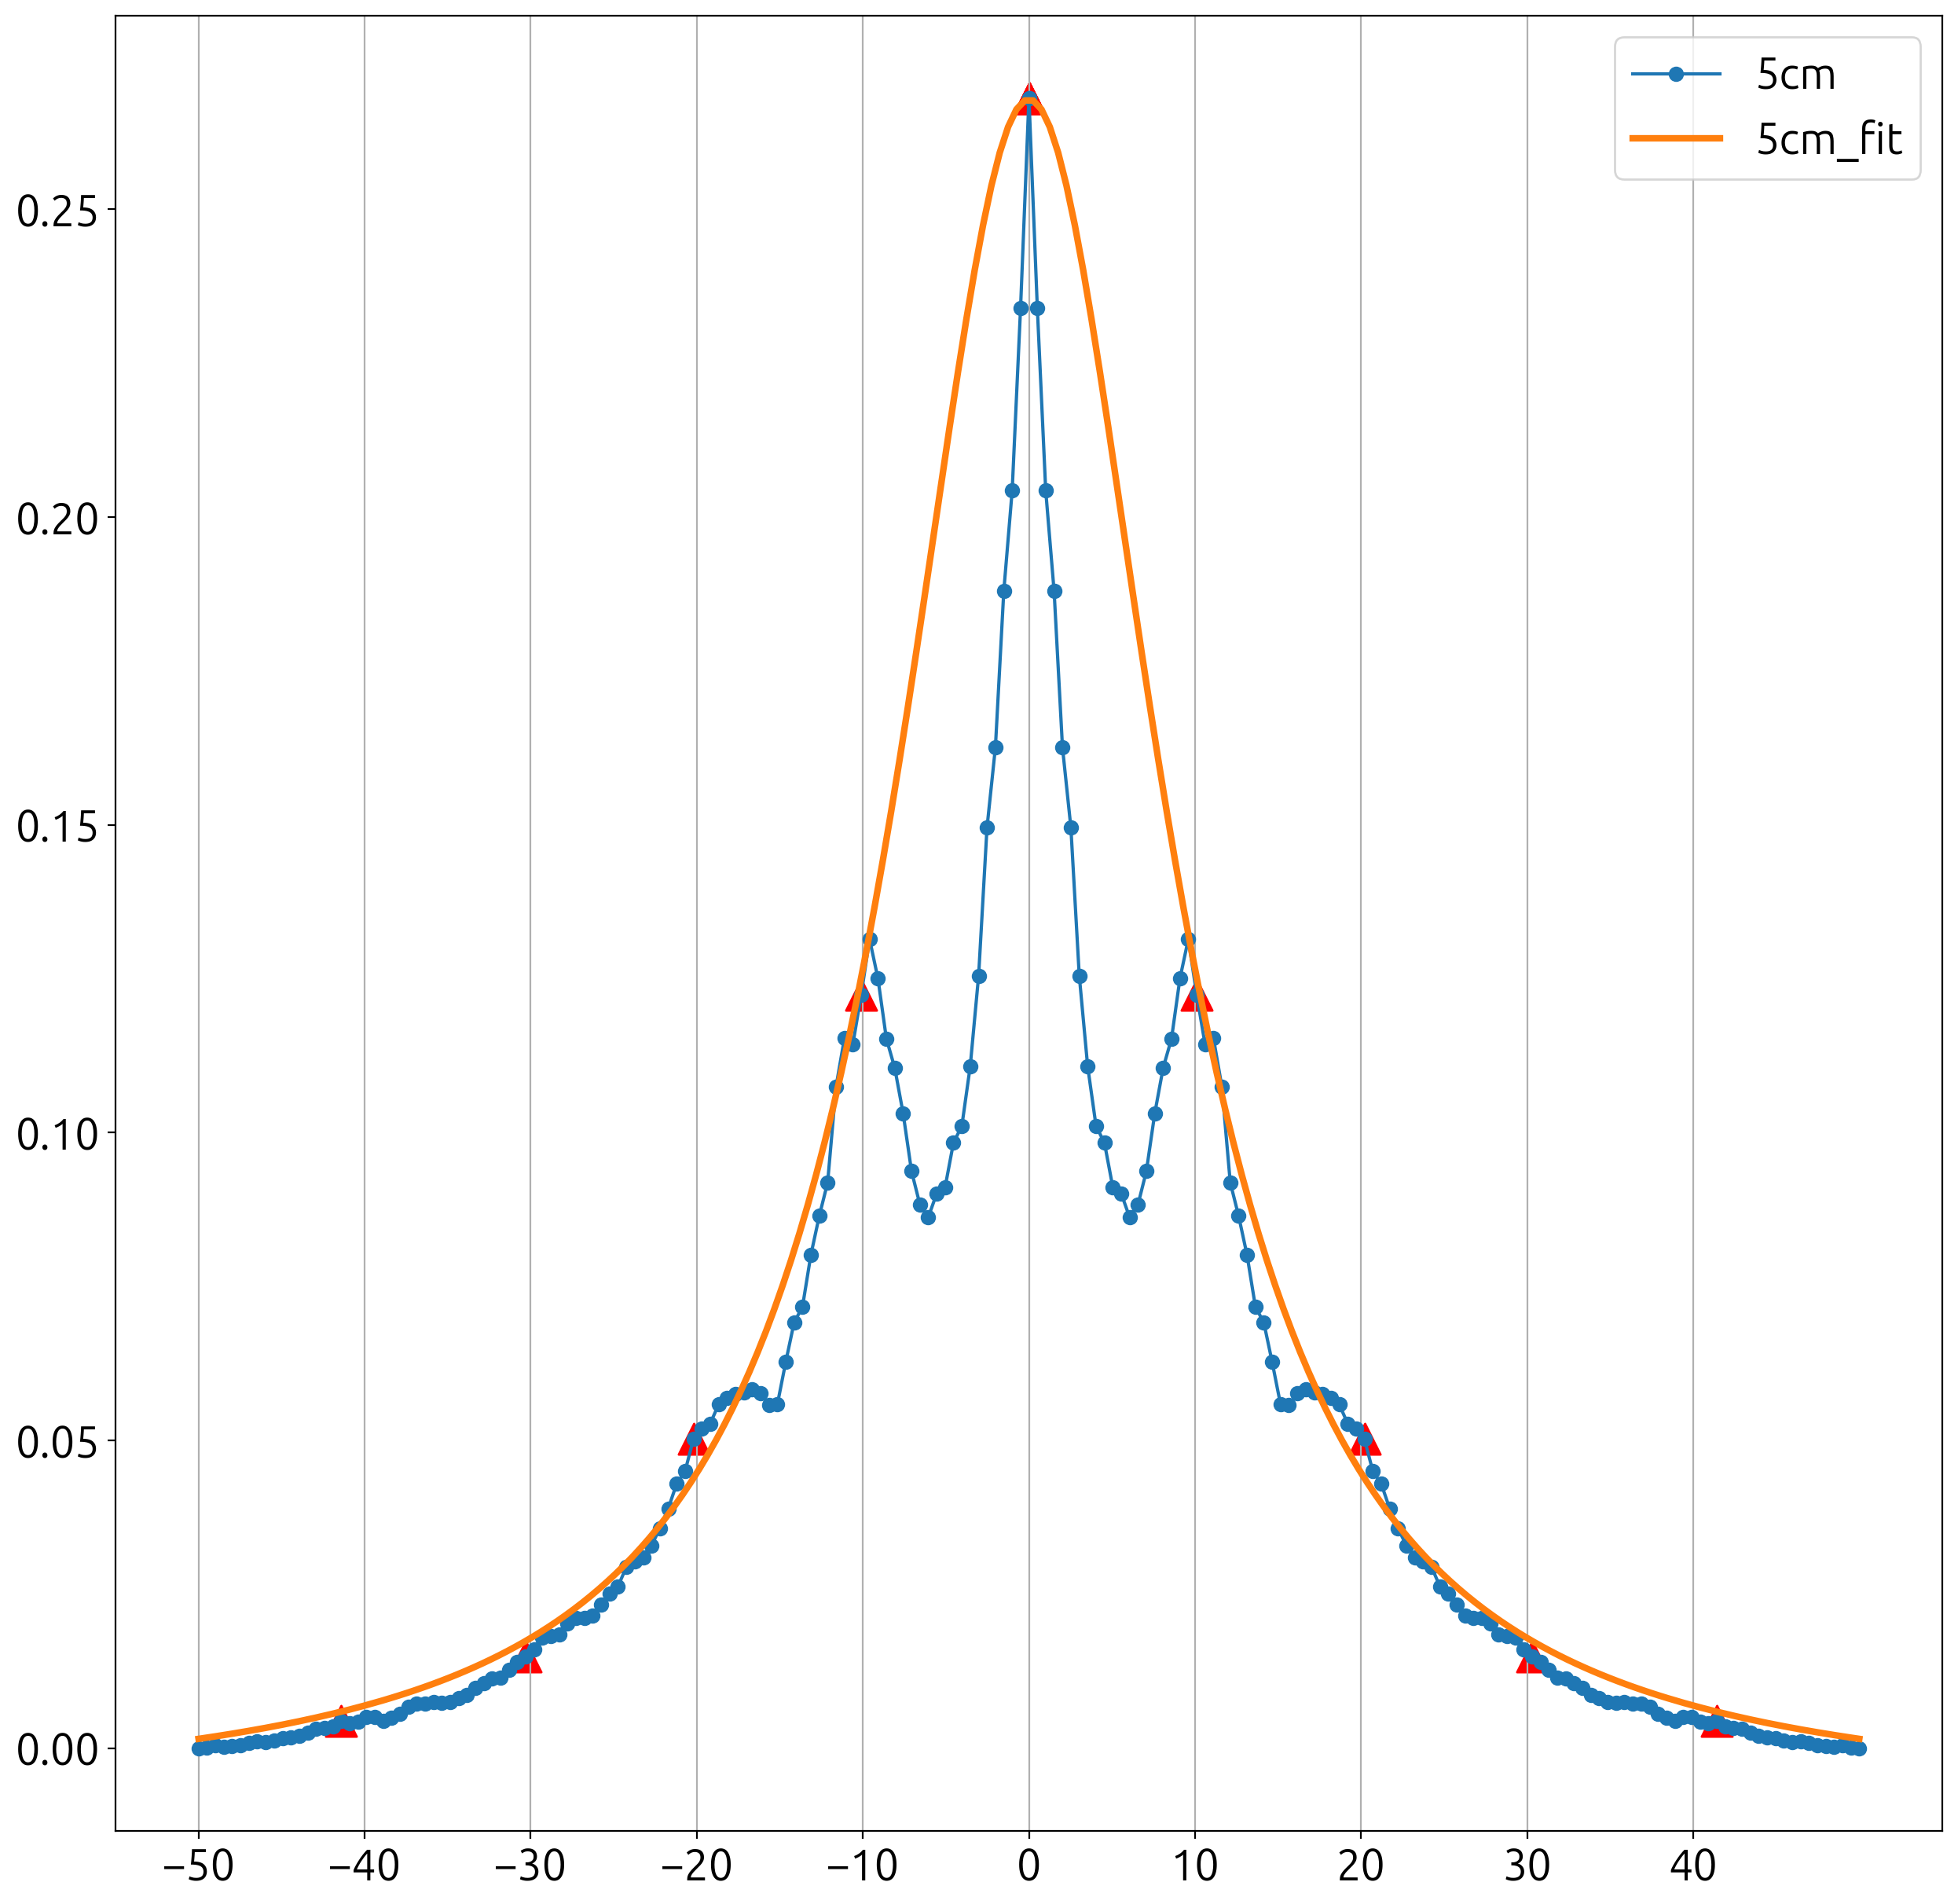

In [217]:
## Gauss PixelPosition,Sigma,Offset
## Lorentz PixelPosition,Gamma,Offset
## Lorentz PixelPosition,Gamma,Sigma,Offset
InitialValues={"Gauss":(1,20),"Lorentz":(1,2,0),"Voigt":(1,1,1,0)}
# (theImage,Radius,NumberOfRings,PixelAmount,centerPoint,DCPixelXMin,DCPixelXMax,step,xLow,xHigh,labelx="Needle",isSame=True)
## Needle 5cm
Fitv5cm={"Img":theImage, # Image of interest
     "Center":Needle5cm_WAvg[0], # Weighted Pixel Mean for the Needle
     "Radius":50, # Maximum Radius the analysis will be performed
     "NumberOfCircles":100, # Number of Co-centric Circles
     "PixelIncrement":1, # Pixel Amount to increment     
     "DCRegion":[-100,-50], # Region for obtainning DC offset
     "PeakRegion":[-50,50], # Region to find the Peaks
     "PeakStep" :10, # Steps taken to find Peaks
     "FitType" : "Lorentz", # Fit Types All or Gaussian,Lorentz,and Voight
     "FitInitals":InitialValues, # Passing Initials for fitting parameters
     "labelx":"5cm", # Label for Plotting
     "isPlot":[True,False], # Show Plot and Plot together 
     "maxfev":10000,   # Max Itteration 
     "isVLines":[False,0,60,9.4] # Draw Lines to determine Magnification, True for Drawing ,start,end,increment 
    }

plt.figure(figsize=(15,15),dpi=200)
Needle5=Obtain1DFit(Fitv5cm)
print(f"Needle 5cm sigma is {Needle5[0][2]}")
print(Needle5[0])

Running Peak Finder Algorithm ..
Max time is 60
Min time is -60
Event Length is 400
Max Pixel is reached
Number of Peaks is 14
13.596712958287402


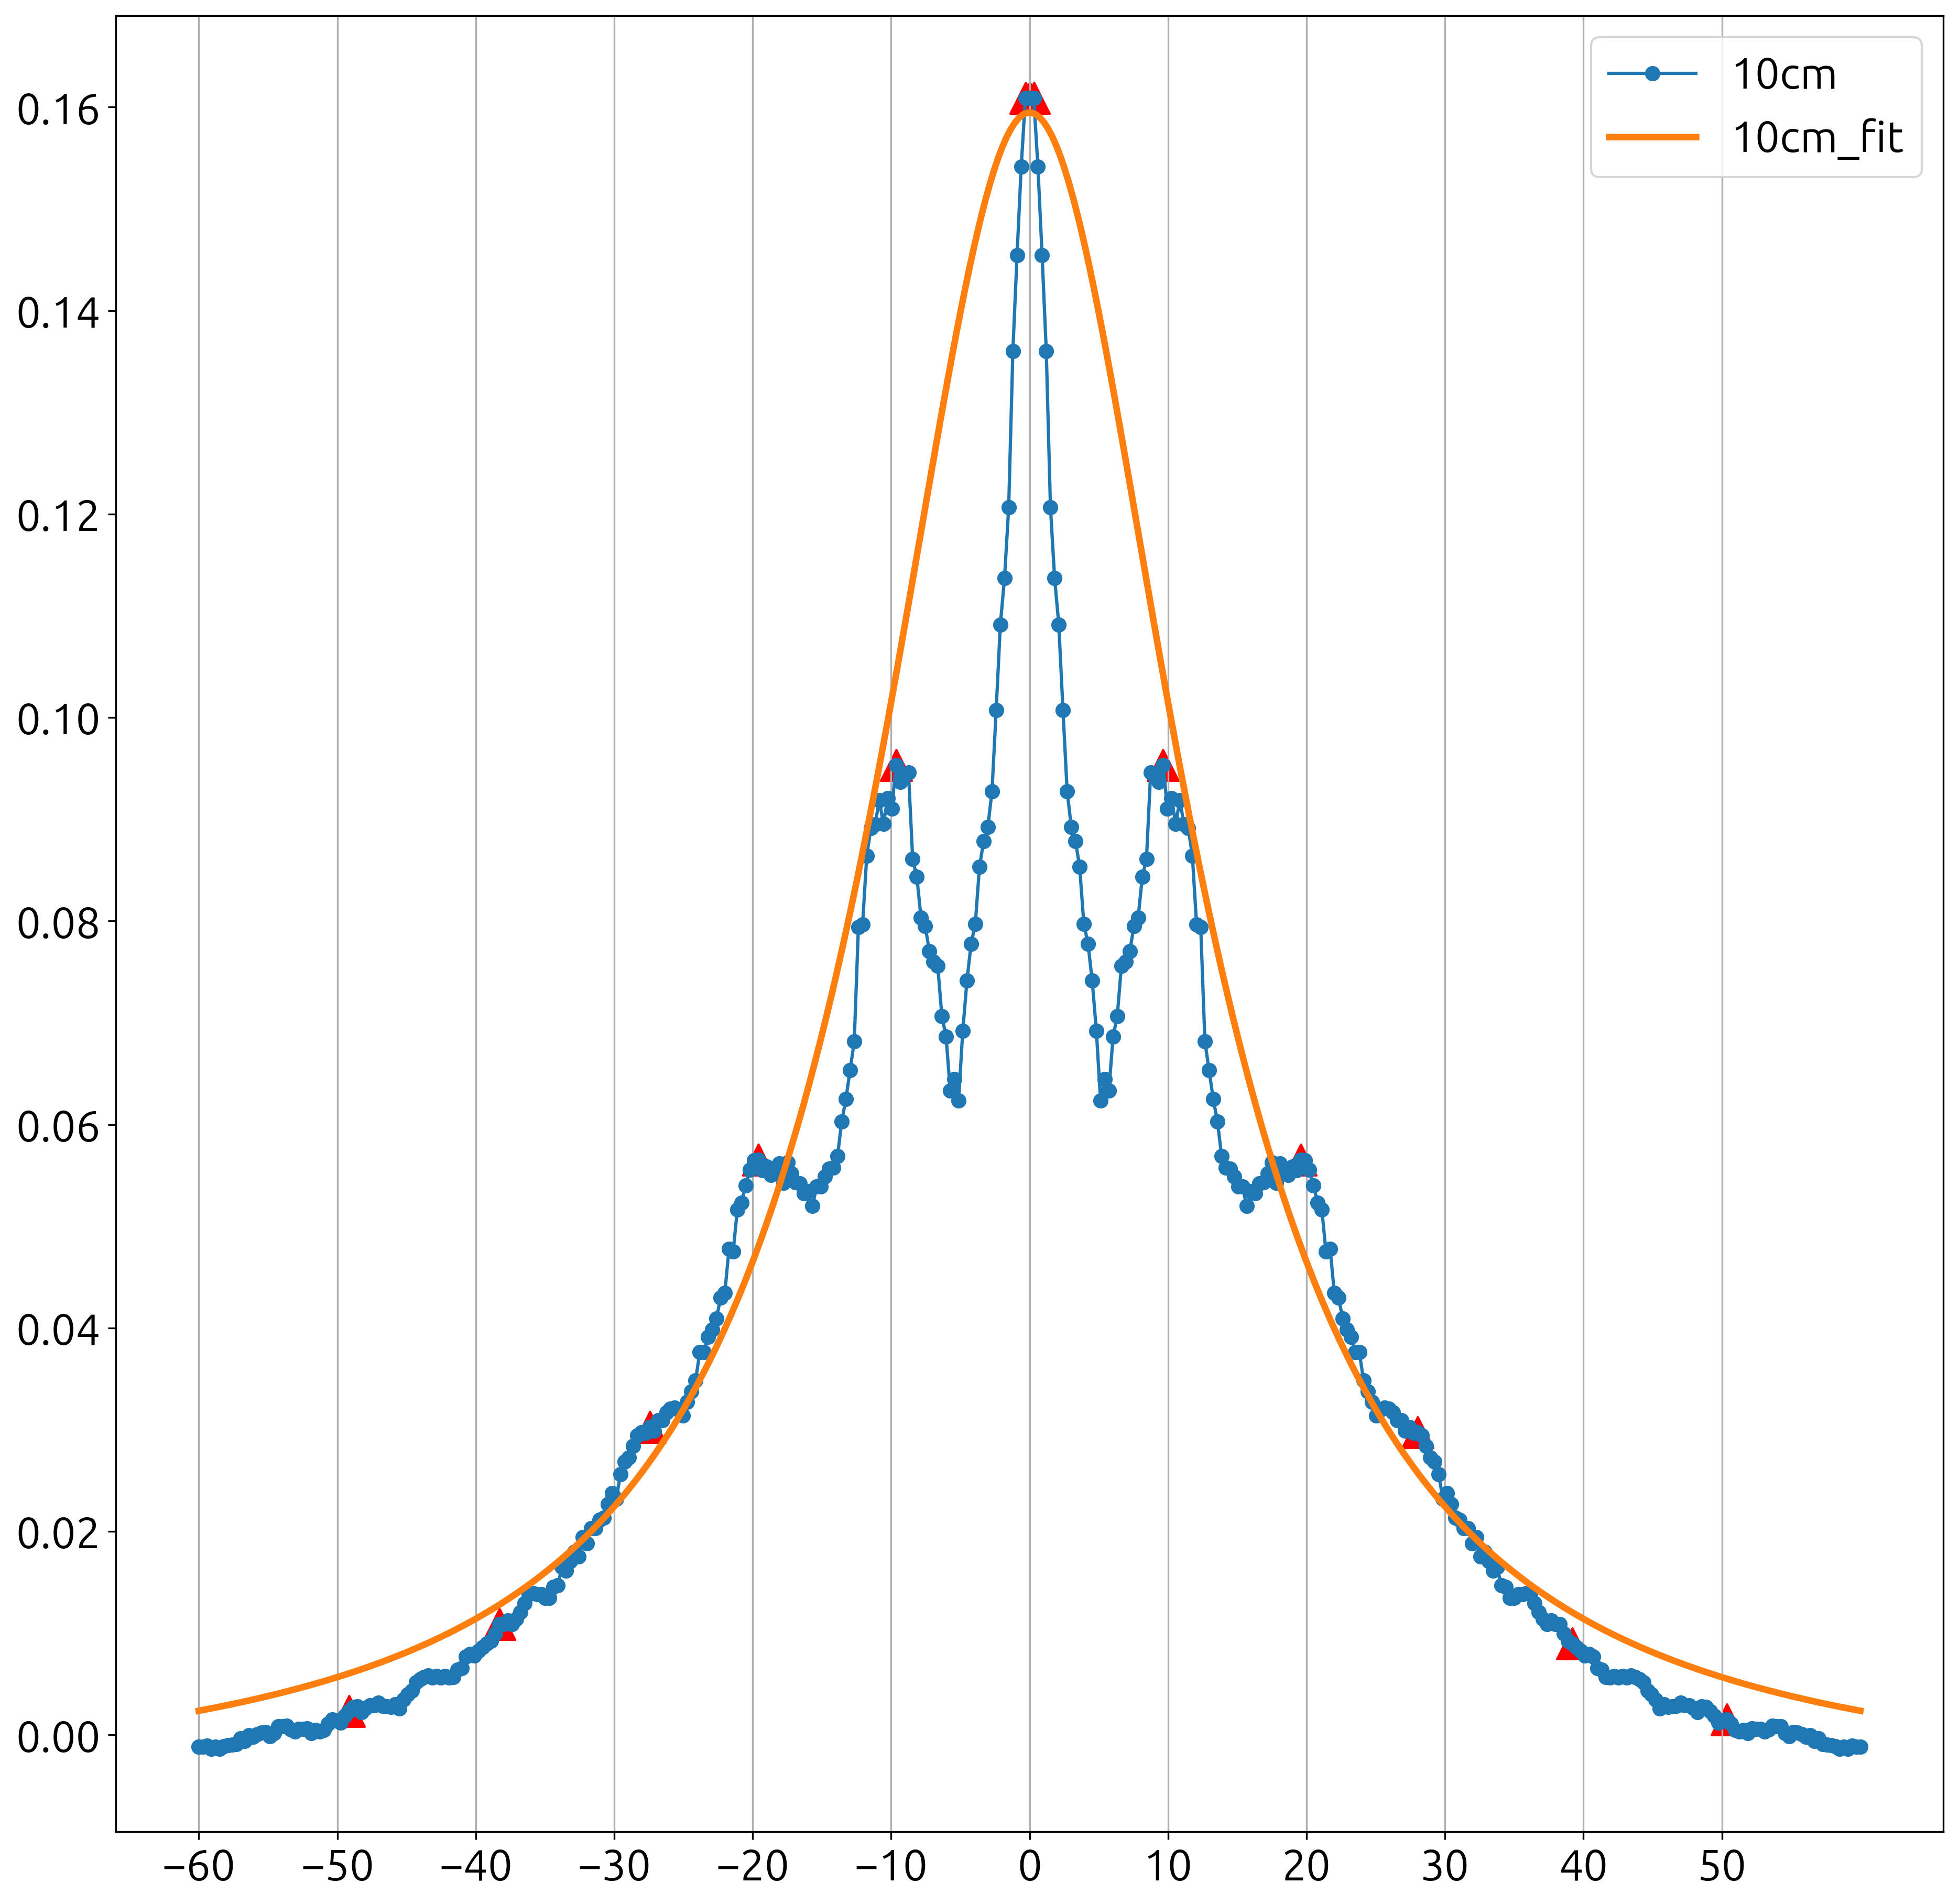

In [218]:
## Needle 10cm

## Gauss PixelPosition,Sigma,Offset
## Lorentz PixelPosition,Gamma,Offset
## Lorentz PixelPosition,Gamma,Sigma,Offset
InitialValues={"Gauss":(1,30),"Lorentz":(1,1,0),"Voigt":(0,1,1,0)}
# (theImage,Radius,NumberOfRings,PixelAmount,centerPoint,DCPixelXMin,DCPixelXMax,step,xLow,xHigh,labelx="Needle",isSame=True)

Fitv10cm={"Img":theImage, # Image of interest
     "Center":Needle10cm_WAvg[0], # Weighted Pixel Mean for the Needle
     "Radius":60, # Maximum Radius the analysis will be performed
     "NumberOfCircles":200, # Number of Co-centric Circles
     "PixelIncrement":1, # Pixel Amount to increment     
     "DCRegion":[-60,-50], # Region for obtainning DC offset
     "PeakRegion":[-60,60], # Region to find the Peaks
     "PeakStep" :11, # Steps taken to find Peaks
     "FitType" : "Lorentz", # Fit Types All or Gaussian,Lorentz,and Voight
     "FitInitals":InitialValues, # Passing Initials for fitting parameters
     "labelx":"10cm", # Label for Plotting
     "isPlot":[True,False], # Show Plot and Plot together 
     "maxfev":10000,   # Max Itteration
     "isVLines":[False,0,60,9.4] # Draw Lines to determine Magnification, True for Drawing ,start,end,increment 

    }



plt.figure(figsize=(15,15),dpi=300)
Needle10=Obtain1DFit(Fitv10cm)
print(Needle10[0][2])
#print(f"Needle 10cm sigma is {Needle10[0][2]}")

Running Peak Finder Algorithm ..
Max time is 60
Min time is -60
Event Length is 400
Max Pixel is reached
Number of Peaks is 16
Needle 15cm sigma is 13.327216979064511
13.327216979064511


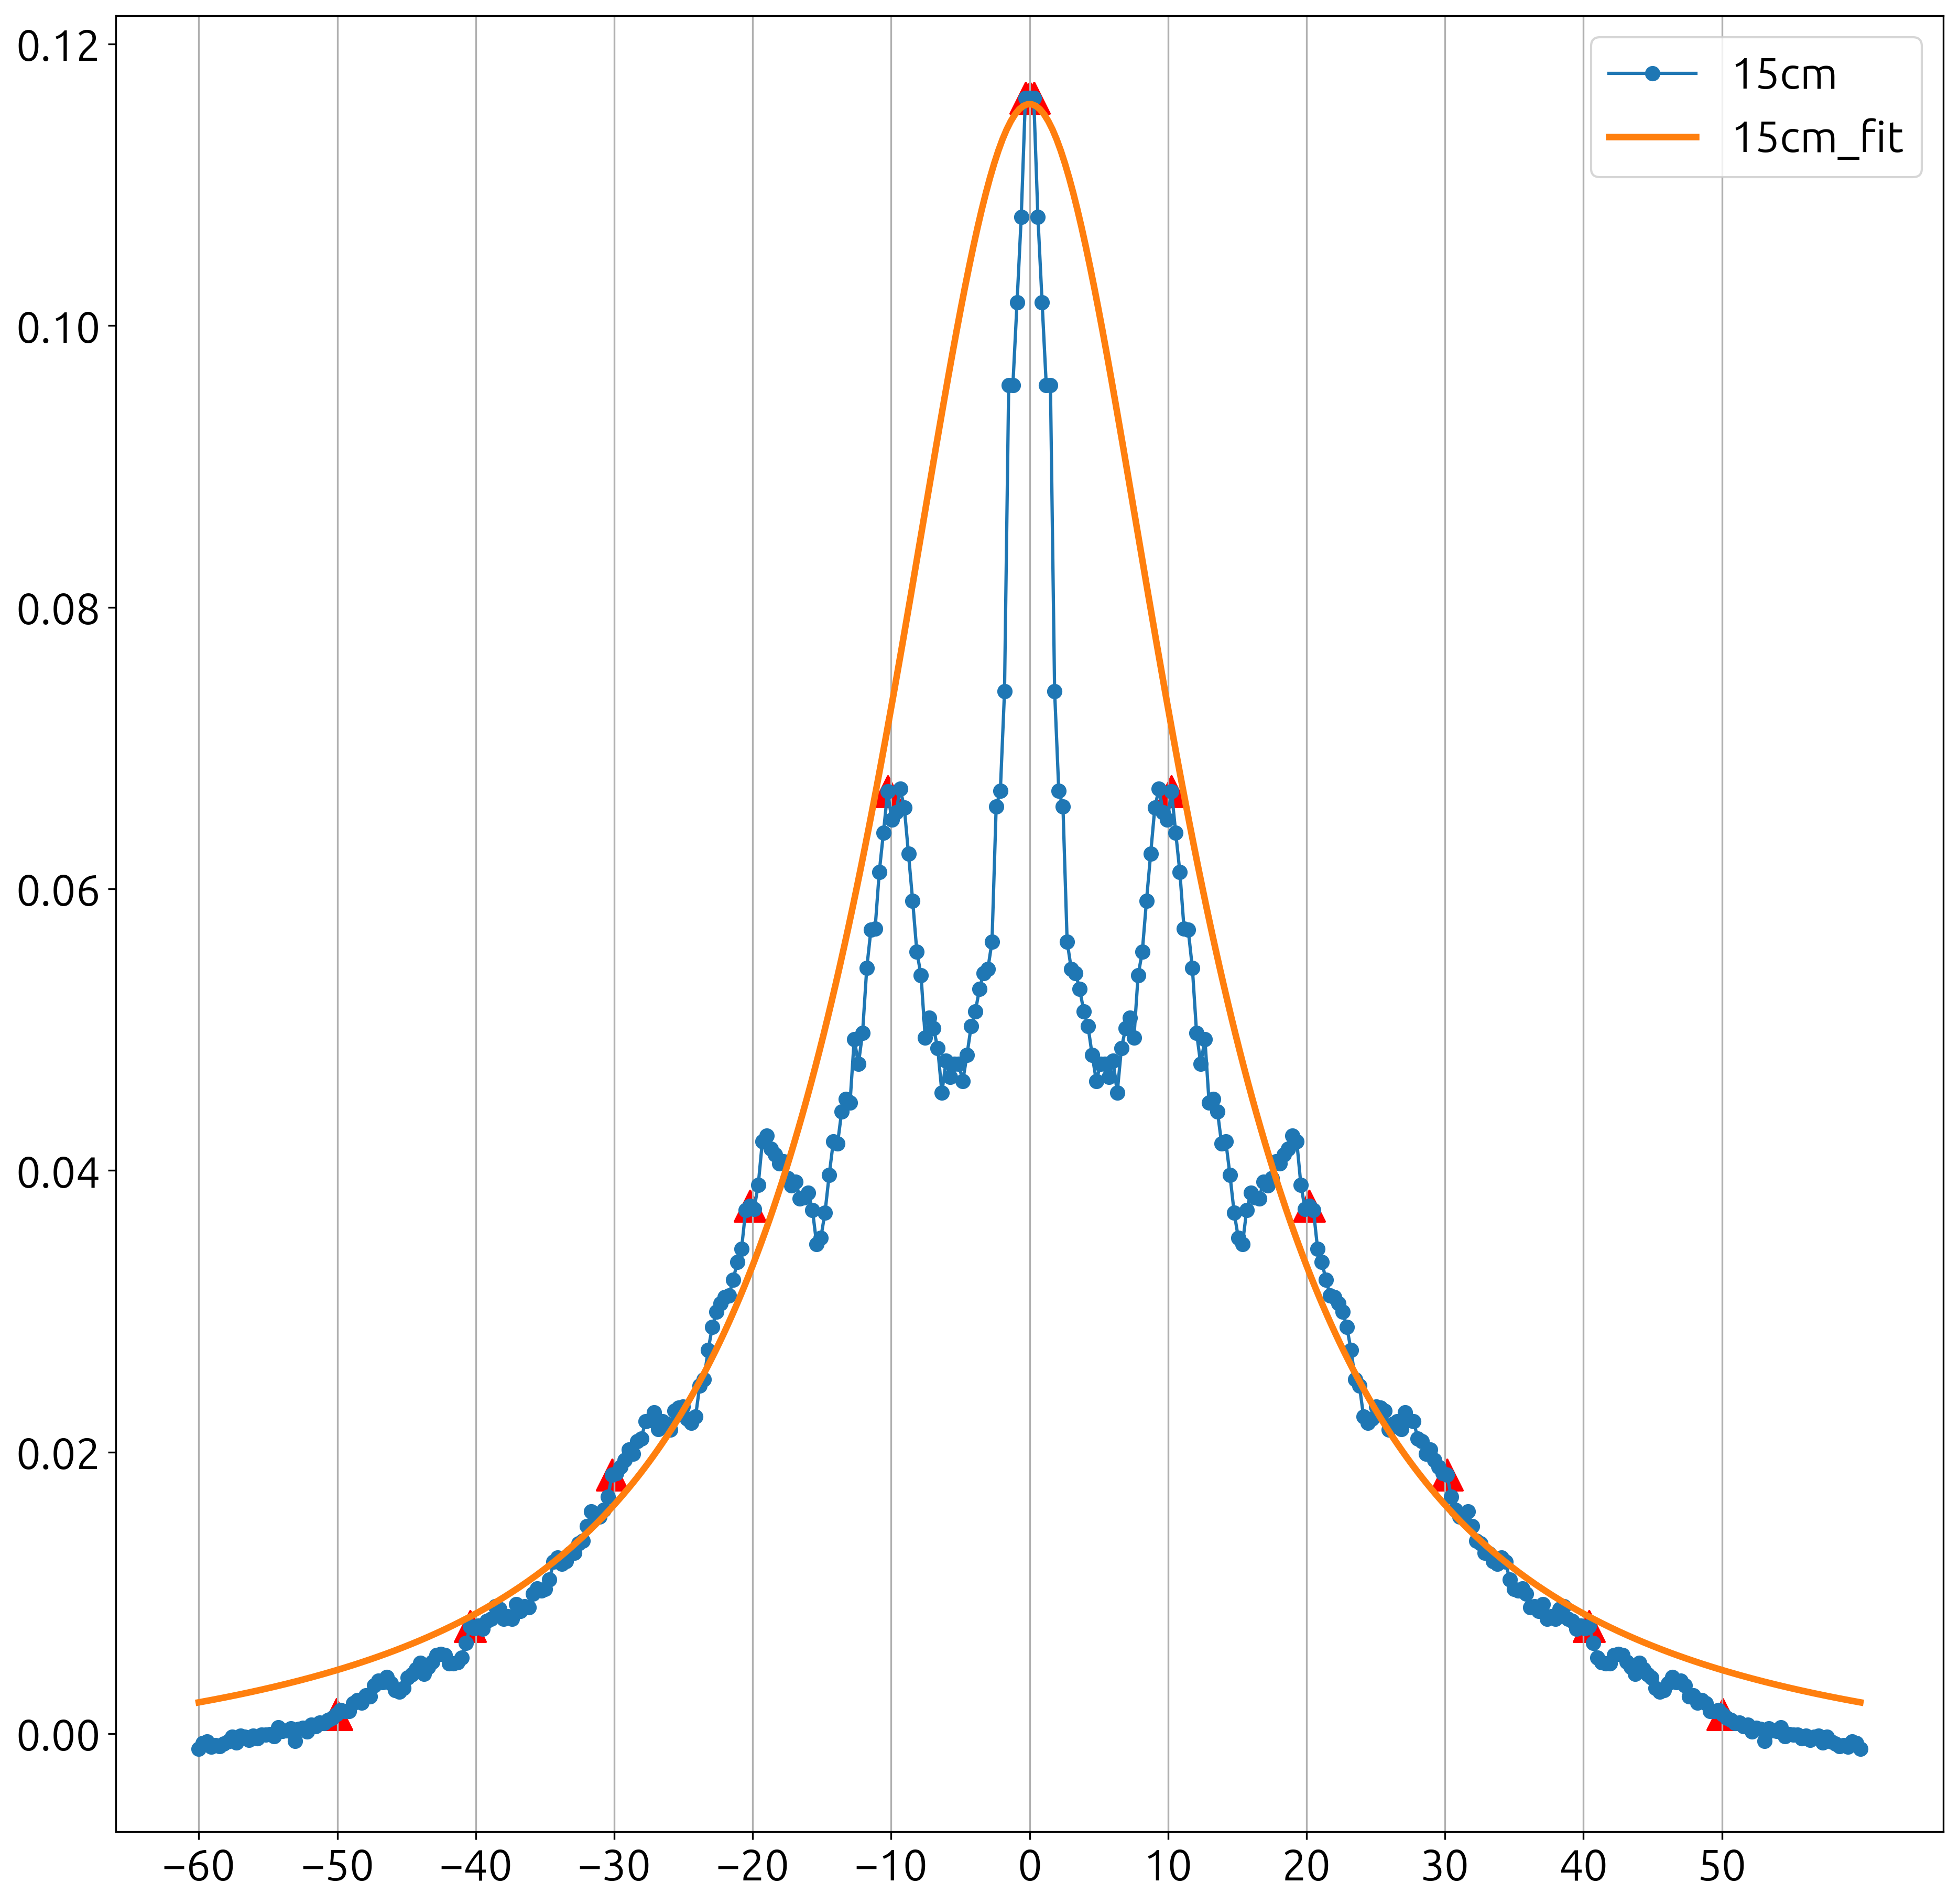

In [219]:

## Needle 15cm

## Gauss PixelPosition,Sigma,Offset
## Lorentz PixelPosition,Gamma,Offset
## Lorentz PixelPosition,Gamma,Sigma,Offset
InitialValues={"Gauss":(1,20),"Lorentz":(1,2,0),"Voigt":(1,0.1,2,0)}
# (theImage,Radius,NumberOfRings,PixelAmount,centerPoint,DCPixelXMin,DCPixelXMax,step,xLow,xHigh,labelx="Needle",isSame=True)

Fitv15cm={"Img":theImage, # Image of interest
     "Center":Needle15cm_WAvg[0], # Weighted Pixel Mean for the Needle
     "Radius":60, # Maximum Radius the analysis will be performed
     "NumberOfCircles":200, # Number of Co-centric Circles
     "PixelIncrement":1, # Pixel Amount to increment     
     "DCRegion":[-60,-50], # Region for obtainning DC offset
     "PeakRegion":[-60,60], # Region to find the Peaks
     "PeakStep" :10, # Steps taken to find Peaks
     "FitType" : "Lorentz", # Fit Types All or Gaussian,Lorentz,and Voight
     "FitInitals":InitialValues, # Passing Initials for fitting parameters
     "labelx":"15cm", # Label for Plotting
     "isPlot":[True,False], # Show Plot and Plot together 
     "maxfev":10000,   # Max Itteration
     "isVLines":[False,0,60,9.4] # Draw Lines to determine Magnification, True for Drawing ,start,end,increment 
    }
plt.figure(figsize=(15,15),dpi=300)
Needle15=Obtain1DFit(Fitv15cm)
print(f"Needle 15cm sigma is {Needle15[0][2]}")
print(Needle15[0][2])

0.759882016399096


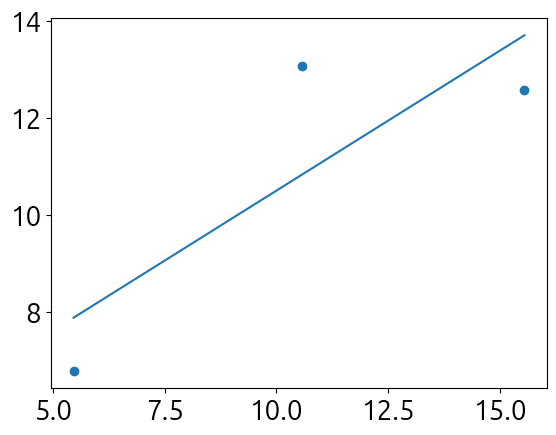

In [220]:
NeedleDistances=np.array([5.46,10.58,15.55])
DD=np.array([Needle5[0][2],Needle10[0][2],Needle15[0][2]])*pixelSize*Magnefication
slope, intercept = np.polyfit(NeedleDistances, DD**2, 1)
plt.scatter(NeedleDistances,DD**2)
plt.plot(NeedleDistances,(slope*NeedleDistances+intercept))
print(np.sqrt(slope))


In [23]:




#plt.figure(figsize=(15,15),dpi=300)

#Hxp=9.4
#plt.axvline(Hxp,0,color="black")
#plt.axvline(0,0,color="black")
#plt.axvline(2*Hxp,0,color="black")
#plt.axvline(3*Hxp,0,color="black")
#plt.axvline(4*Hxp,0,color="black")



[1.55988085 1.08634293 1.04001695]
Dt is 0.5896620936654347 mm/sqrt(cm)
3.2458619405797844


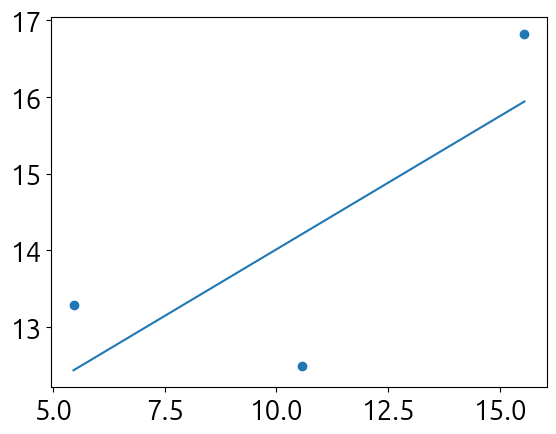

In [24]:
NeedleDistances=np.array([5.46,10.58,15.55])
datayy=np.array([Needle5[0][2],Needle10[0][2],Needle15[0][2]])*pixelSize*Magnefication
plt.scatter(NeedleDistances,datayy**2)
slope, intercept = np.polyfit(NeedleDistances, datayy**2, 1)
plt.plot(NeedleDistances,(slope*NeedleDistances+intercept))
print(datayy/np.sqrt(NeedleDistances))
print(f"Dt is {np.sqrt(slope)} mm/sqrt(cm)")
print(np.sqrt(intercept))

(275.0, 315.0)

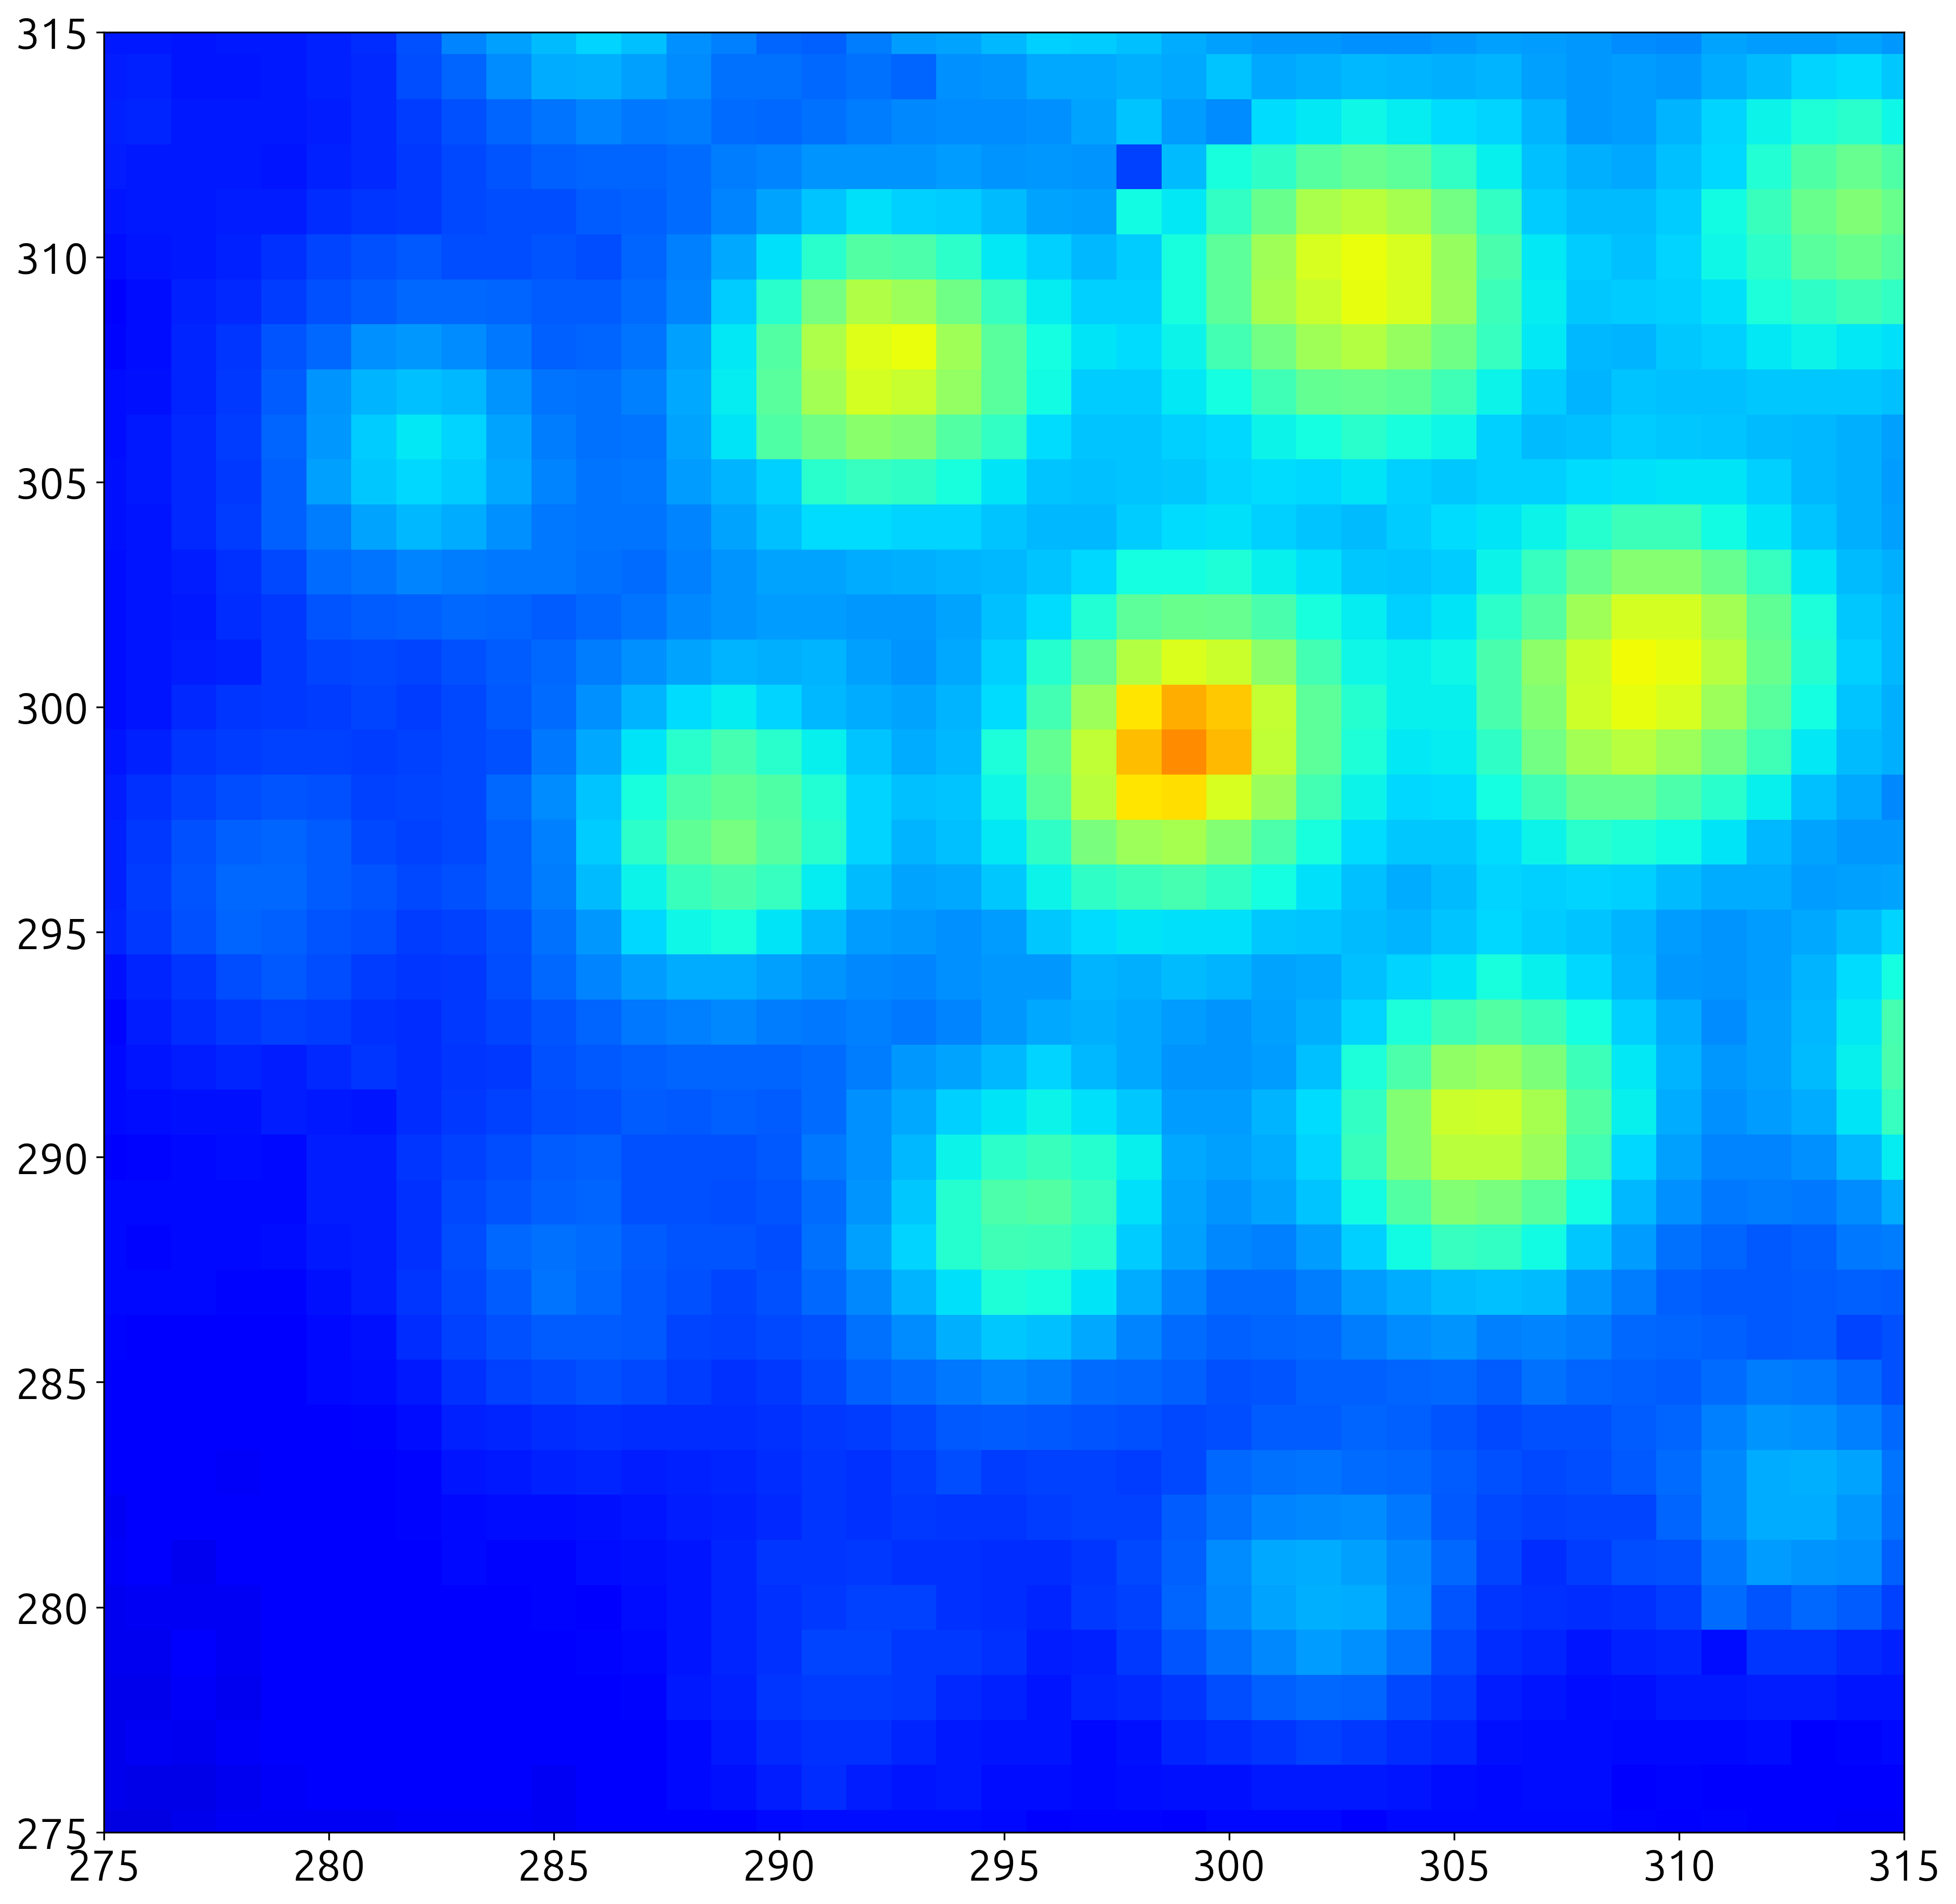

In [25]:

NoiseMean=np.mean(theImage[Noise[0]])
NoiseMatrix=np.ones(theImage.shape)*NoiseMean
#theImage=theImage-NoiseMatrix
plt.figure(figsize=(15,15),dpi=300)
plt.imshow(theImage,cmap=plt.cm.jet,origin='lower',vmin=np.mean(theImage),vmax=np.max(theImage))
plt.xlim(275,315)
plt.ylim(275,315)


In [26]:
#plt.imshow(Particles["Alphas"][2],vmin=np.mean(Particles["Alphas"][2]),vmax=np.max(Particles["Alphas"][2])*0.6)

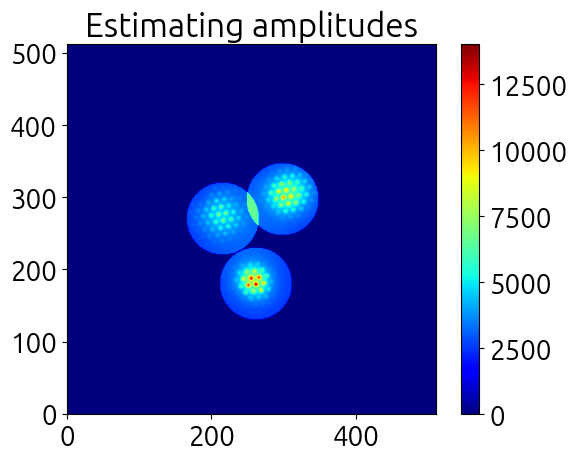

In [27]:

FinalImage=Needle10cm_Mask[1]*theImage+theImage*Needle5cm_Mask[1]+theImage*Needle15cm_Mask[1]
plt.title("Estimating amplitudes")
plt.imshow(FinalImage,cmap=plt.cm.jet,origin='lower')
plt.colorbar()


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


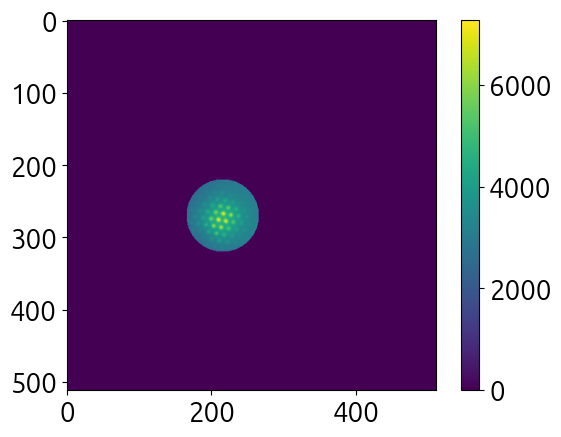

In [28]:
imageLayout=np.zeros((512,512))+theImage*Needle15cm_Mask[1]
print(imageLayout)
mean=np.mean(theImage*Needle15cm_Mask[0])
plt.imshow(imageLayout)
plt.colorbar()

In [29]:
### Initial values

initialGuess_needle_5cm=np.mean(theImage[Needle5cm_Mask[0]]), Needle5cm_Mask[2][0],18, Needle5cm_Mask[2][1],18
initialGuess_needle_10cm=np.mean(theImage[Needle10cm_Mask[0]]), Needle10cm_Mask[2][0], 20, Needle10cm_Mask[2][1],20
initialGuess_needle_15cm=np.mean(theImage[Needle15cm_Mask[0]]), Needle15cm_Mask[2][0], 25, Needle15cm_Mask[2][1],25
offset=0.5


print(np.mean(theImage[Needle15cm_Mask[0]]))
print(np.mean(theImage[Needle10cm_Mask[0]]))
print(np.mean(theImage[Needle5cm_Mask[0]]))

3517.160771458999
3998.607054739084
3760.050503088392


In [30]:
def Sumsof3Gaussian(xy,*initials):
    fit1=initials[0:5]
    fit2=initials[5:10]
    fit3=initials[10:15]
    offset=initials[-1:]
    Sum=TwoDGaussian(xy,*fit1)+TwoDGaussian(xy,*fit2)+TwoDGaussian(xy,*fit3)+offset
    return Sum.ravel()

def FitSumsof3Gaussian(img,fit1,fit2,fit3,offset,it=15000):
    x = np.linspace(0,img.shape[0],img.shape[0])
    xx, yy = np.meshgrid(x, x)
    flattened=img.ravel()
    popt, pcov = opt.curve_fit(Sumsof3Gaussian, (xx, yy),flattened , p0=(*fit1,*fit2,*fit3,offset),maxfev=it,method="dogbox")
    print(popt)
    data_fitted = Sumsof3Gaussian((xx, yy),*popt)
    return flattened.reshape(512,512),data_fitted.reshape(512,512),[xx,yy],popt
    

In [31]:
Fit_3Gaussian=FitSumsof3Gaussian(theImage,initialGuess_needle_5cm,initialGuess_needle_10cm,initialGuess_needle_15cm,offset)

[6092.00394686  259.07035983   17.62654656  183.97904597   17.44229467
 4516.00594843  306.45566047   22.91857483  304.80390711   24.47464008
 2453.65570547  218.3633996    31.8968296   272.27365142   33.66472316
 2107.25851331]


In [32]:
print(Fit_3Gaussian[3][4])


17.442294670131197


In [33]:
def ConvertToDiffusion(SigmaX,SigmaY,distance,pixelSize,Magnefication,DT=0.92):
    DTX=round((SigmaX/np.sqrt(distance))*pixelSize*Magnefication,2)
    DTY=round((SigmaY/np.sqrt(distance))*pixelSize*Magnefication,2)
    value=round((DTX+DTY)/2,2)
    Error=round(abs(DT-value)/DT,2)
    print(f"Needle Distance is {distance} cm")
    print(f"DT is {value} mm/sqrt(cm) error is {Error*100} %")

def GetTransVerseDiffusion(Fit,pixelSize,mag):
    DTs=np.array([])
    SigmaXs=np.array([])
    SigmaYs=np.array([])
    positions=[2,7,12]
    
    for i in positions:
        DTX=round(Fit[3][i]*pixelSize,2)
        DTY=round(Fit[3][i+2]*pixelSize,2)
        DT=round((DTX+DTY)/2,2)*mag
        
        DTs=np.append(DTs,DT)
        SigmaXs=np.append(SigmaXs,Fit[3][i])
        SigmaYs=np.append(SigmaYs,Fit[3][i+2])
        
    #Error=round(abs(DT-value)/DT,2)
    return DTs,SigmaXs,SigmaYs
    

In [34]:
Diffusion=GetTransVerseDiffusion(Fit_3Gaussian,pixelSize,Magnefication)

In [35]:
print(Diffusion)

(array([4.65425532, 6.31648936, 8.64361702]), array([17.62654656, 22.91857483, 31.8968296 ]), array([17.44229467, 24.47464008, 33.66472316]))


2.2911033515481343 nan
[4.65425532 6.31648936 8.64361702]


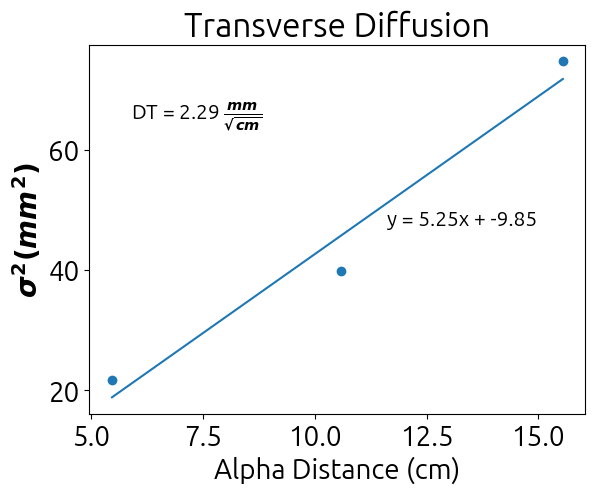

In [36]:
plt.title("Transverse Diffusion")
plt.xlabel("Alpha Distance (cm)")
plt.ylabel(r'$\sigma^2 (mm^2)$')
NeedleDistances=np.array([5.46,10.58,15.55])
#NeedleDistances=np.sqrtNeedleDistances)
slope, intercept = np.polyfit(NeedleDistances, Diffusion[0]**2, 1)
plt.scatter(NeedleDistances,Diffusion[0]**2)
plt.plot(NeedleDistances,(slope*NeedleDistances+intercept))

DT=np.round(np.sqrt(slope),2)

print(np.sqrt(slope),np.sqrt(intercept))

plt.text(0.35,0.85,f"DT = {DT} " + r"$\frac{mm}{\sqrt{cm}}$",fontsize=15,horizontalalignment='right',verticalalignment='top',transform = plt.gca().transAxes)
#plt.text(5.8, 14, f"DT={D}" + r"$\frac{mm}{\sqrt{cm}}$", bbox=dict(facecolor='blue', alpha=0.5))
plt.text(0.6, 0.5,f"y = {round(slope,2)}x + {round(intercept,2)} ",fontsize=15,horizontalalignment='left',verticalalignment='bottom',transform = plt.gca().transAxes)
print(Diffusion[0])


17.62654655615225 17.442294670131197
22.91857482890125 24.474640079608562
31.896829599638014 33.66472316496475
Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions
 
Needle Distance is 5.46 cm
DT is 2.0 mm/sqrt(cm) error is 117.0 %
Needle Distance is 10.58 cm
DT is 1.94 mm/sqrt(cm) error is 111.00000000000001 %
Needle Distance is 15.55 cm
DT is 2.21 mm/sqrt(cm) error is 140.0 %


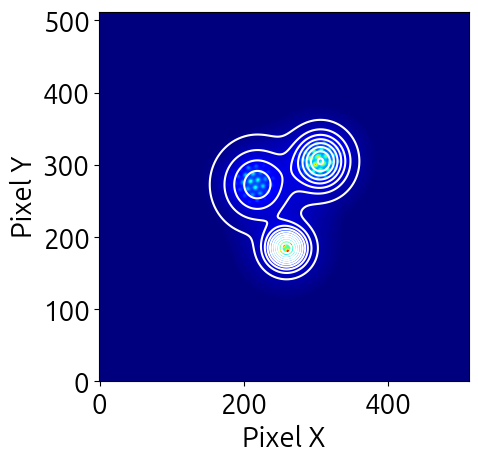

In [37]:

#ax[0].imshow(firstFit[0], cmap=plt.cm.jet, origin='lower',extent=(xx.min(), xx.max(), yy.min(), yy.max()))
plt.imshow(Fit_3Gaussian[0], cmap=plt.cm.jet, origin='lower',vmin=np.mean(theImage),vmax=np.max(theImage))
plt.contour(Fit_3Gaussian[2][0], Fit_3Gaussian[2][1], Fit_3Gaussian[1], 10, colors='w')

plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

#print(Fit_3Gaussian[3])
print(Fit_3Gaussian[3][2],Fit_3Gaussian[3][4])
print(Fit_3Gaussian[3][2+5],Fit_3Gaussian[3][4+5])
print(Fit_3Gaussian[3][2+10],Fit_3Gaussian[3][4+10])


#print("Converting...")
print(f"Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions")
print(" ")
ConvertToDiffusion(Fit_3Gaussian[3][2],Fit_3Gaussian[3][4],5.46,pixelSize,Magnefication)
ConvertToDiffusion(Fit_3Gaussian[3][2+5],Fit_3Gaussian[3][4+5],10.58,pixelSize,Magnefication)
ConvertToDiffusion(Fit_3Gaussian[3][2+10],Fit_3Gaussian[3][4+10],15.55,pixelSize,Magnefication)



In [38]:
x=np.array([1,10,1,1,1,10,5,100,10])

In [39]:
np.mean(x)

15.444444444444445

In [40]:
np.average(x)

15.444444444444445